# Module 3: Supervised Learning
[Computational Genomics Chapter 5](http://compgenomr.github.io/book/supervisedLearning.html)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rdata
import seaborn as sns

### 3.1 How are machine learning models fitted?
* Clustering and dimension reduction techniques can use optimization methods, but they do so without having a correct answer to predict or train with. In this case, they find patterns or structure in the data without trying to estimate a correct answer.
* Machine learning models are optimization methods at their core. They all depend on defining a “cost” or “loss” function to minimize. For example, in linear regression the difference between the predicted and the original values are being minimized. When we have a data set with the correct answer such as original values or class labels, this is called supervised learning

Basic algorithm:
1. Define a prediction function or method $f(X)$.
2. Devise a function (called the loss or cost function) to optimize the difference between your predictions and observed values, such as $\sum (Y-f(X))^2$.
3. Apply mathematical optimization methods to find the best parameter values for $f(X)$ in relation to the cost/loss function.

Steps in supervised machine learning:
1. Pre-processing data: normalization & data transformation procedures
2. Training and test data split
3. Training the model: “Training" generally means your data set is used in optimization of the loss function to find parameters for $f(X)$
4. Estimating performance of the model: Deciding which metrics to use to evaluate performance and how to calculate those metrics.
5. Model tuning and selection: Try different parameters and select the best model.

### 3.2 Data preprocessing

In [2]:
# Load the cancer rna subset dataset with CpG island methylator phenotype (CIMP)
r_data = rdata.parser.parse_file("/Users/olyssa/Downloads/compGenomRData-1-2.0/inst/extdata/LGGrnaseq.rds")
as_dict = rdata.conversion.convert(r_data)
gexp = pd.DataFrame(as_dict)
gexp = gexp.set_axis(list(as_dict.dim_1.to_numpy()), axis=1)
gexp = gexp.set_axis(list(as_dict.dim_0.to_numpy()), axis=0)
gexp.head()

,TCGA-CS-4941,TCGA-CS-4944,TCGA-CS-5393,TCGA-CS-5394,TCGA-CS-5395,TCGA-CS-5396,TCGA-CS-5397,TCGA-CS-6186,TCGA-CS-6188,TCGA-CS-6669,...,TCGA-TM-A84S,TCGA-TQ-A7RI,TCGA-TQ-A7RP,TCGA-TQ-A7RR,TCGA-TQ-A8XE,TCGA-VM-A8C9,TCGA-VM-A8CD,TCGA-VM-A8CF,TCGA-VW-A8FI,TCGA-WY-A859
A1BG,72.2326,24.7132,46.3789,37.9659,19.5162,90.6419,157.9335,221.6867,174.8391,58.8621,...,104.7671,57.8723,114.1298,140.9732,114.4107,294.1675,37.9831,525.5287,149.7735,67.6466
A1CF,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.4552,...,0.0000,0.4172,0.0000,0.0000,0.3660,0.0000,0.0000,0.0000,0.0000,0.0000
A2BP1,524.4997,105.4092,323.5828,19.7390,299.5375,11.0438,1646.5054,18.8235,69.8011,4608.5571,...,81.6049,174.3846,284.1710,510.7475,33.3089,125.4378,119.6291,21.9033,25.0298,2435.7939
A2LD1,144.0856,18.0154,29.0942,7.5945,202.1231,17.5750,54.2608,76.0817,71.9060,33.6413,...,30.4386,26.4622,169.0268,40.7486,26.8082,49.2200,56.2291,33.2477,91.8296,21.7057
A2ML1,521.3941,159.3746,164.6157,63.5664,953.4106,15.0318,526.5457,2173.6223,65.0995,55.5303,...,301.0314,188.9862,709.3289,467.5436,65.8858,16.5552,658.1315,172.2054,70.9178,227.7500


In [3]:
r_data = rdata.parser.parse_file("/Users/olyssa/Downloads/compGenomRData-1-2.0/inst/extdata/patient2LGGsubtypes.rds")
as_dict = rdata.conversion.convert(r_data)
patient = pd.DataFrame(as_dict)
patient.head()

,subtype
TCGA-FG-8185,CIMP
TCGA-DB-5276,CIMP
TCGA-P5-A77X,CIMP
TCGA-IK-8125,CIMP
TCGA-DU-A5TR,CIMP


#### 3.2.1 Data normalization and transformation

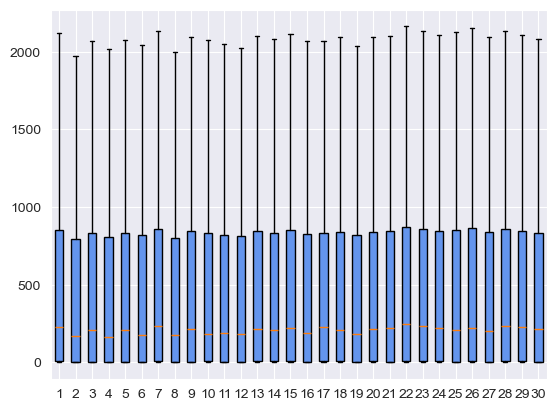

In [4]:
# Boxplots for the first 30 gene expression values

plt.boxplot(gexp.iloc[:, :30], patch_artist=True, showfliers=False, boxprops=dict(facecolor="cornflowerblue"))
plt.show()

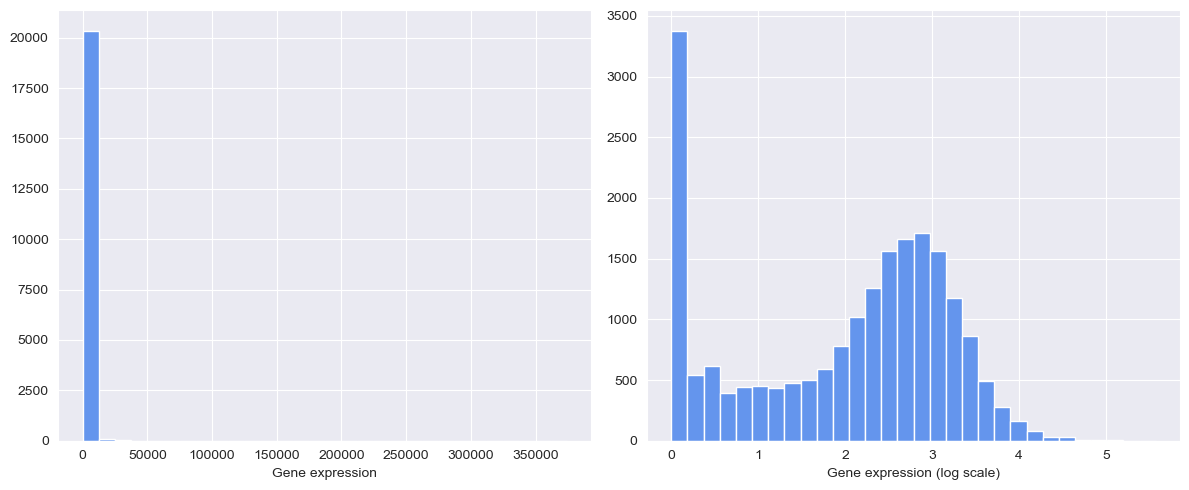

In [5]:
#  Gene expression distribution for the 5th patient (left) & Log transformed gene expression distribution for the same patient (right)

gene_expression = gexp.iloc[:, 4]  
log_gene_expression = np.log10(gexp + 1).iloc[:, 4] # taking log10 and adding pseudo-count


plt.figure(figsize=(12, 5)) 

# First histogram: Raw gene expression
plt.subplot(1, 2, 1)
plt.hist(gene_expression, bins=30, color="cornflowerblue")
plt.xlabel("Gene expression")
plt.title("")

# Second histogram: Log-transformed gene expression
plt.subplot(1, 2, 2)
plt.hist(log_gene_expression, bins=30, color="cornflowerblue")
plt.xlabel("Gene expression (log scale)")
plt.title("")

plt.tight_layout()
plt.show()

In [6]:
# Transpose data
gexp_t = gexp.T

#### 3.2.2 Data filtering and scaling

In [7]:
# Filter out near-zero features

from sklearn.feature_selection import VarianceThreshold

# Define a threshold for near-zero variance (85% of values the same)
threshold = 0.85 * (1 - 0.85)  # Variance of a binary variable with 85% identical values

# Initialize the VarianceThreshold filter
nzv_filter = VarianceThreshold(threshold=threshold)

# Apply the filter to the dataset
gexp_t_nzv = nzv_filter.fit_transform(gexp_t)

# Convert back to a pandas DataFrame
gexp_t_nzv = pd.DataFrame(gexp_t_nzv, columns=gexp_t.columns[nzv_filter.get_support()])

In [8]:
# Selecting top 1,000 features with highest standard deviations

# Calculate the standard deviation of each column
SDs = gexp_t.std(axis=0) 

# Get the indices of the top 1,000 columns with the highest standard deviation
topPreds = SDs.nlargest(1000).index

# Subset the gexp_t DataFrame to include only the top 1,000 columns
gexp_t = gexp_t[topPreds]

In [9]:
# Standardize data

from sklearn.preprocessing import StandardScaler

# Initialize the scaler with centering only (no scaling to unit variance)
scaler = StandardScaler(with_mean=True, with_std=False)

# Fit the scaler to the data and transform it
gexp_t_st = scaler.fit_transform(gexp_t)

# Convert back to a pandas DataFrame
gexp_t = pd.DataFrame(gexp_t_st, columns=gexp_t.columns)

In [10]:
# Filter out highly correlated features

# Calculate the correlation matrix
correlation_matrix = gexp_t.corr().abs()

# Identify columns to drop based on the cutoff (0.9 in this case)
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]

# Remove the highly correlated columns
gexp_t = gexp_t.drop(columns=to_drop)

#### 3.2.3 Dealing with missing values

In [11]:
# Check if there are NA values

# Create a copy of tgexp
missing_tgexp = gexp_t.copy()

# Introduce a missing value (NA equivalent in R)
missing_tgexp.iloc[0, 0] = np.nan  # Set the first row, first column to NaN

# Check if there are any missing values
any_missing = missing_tgexp.isnull().values.any()
print(any_missing) 

True


In [12]:
# Remove columns that contain any missing values

gexpnoNA = missing_tgexp.loc[:, missing_tgexp.isnull().sum(axis=0) == 0]

In [13]:
# Impute missing values

from sklearn.impute import SimpleImputer

# Create the imputer that replaces missing values with the median
imputer = SimpleImputer(strategy='median')

# Fit the imputer and transform the data
imputedGexp = pd.DataFrame(imputer.fit_transform(missing_tgexp), columns=missing_tgexp.columns)

In [14]:
from sklearn.impute import KNNImputer

# Create the KNN imputer with a specified number of neighbors (e.g., 5)
knn_imputer = KNNImputer(n_neighbors=5)

# Fit the KNN imputer and transform the data
knnimputedGexp = pd.DataFrame(knn_imputer.fit_transform(missing_tgexp), columns=missing_tgexp.columns)

### 3.3 Splitting the data

#### 3.3.1 Holdout test dataset

* Gold standard: 30 % of the data as test

In [15]:
# Merge patient and gexp_t dataframes

patient['ID'] = patient.index
gexp_t['ID'] = gexp.columns
gexp_t_merged = pd.merge(patient, gexp_t, on='ID', how='left')
gexp_t_merged.index = gexp_t_merged.index 
gexp_t_merged.head()

,subtype,ID,GFAP,CLU,TTR,SPARC,MBP,PLP1,CHI3L1,BCAN,...,KIF21B,SGK1,STAB1,CD68,MMP14,FAM84B,CSNK1E,PPP1CB,TRIO,IQSEC1
0,CIMP,TCGA-FG-8185,-370142.91494,-135127.268781,-13788.740185,-22574.170261,-57697.782656,-35291.313577,-18104.372229,105518.611502,...,-262.462664,3633.22604,-482.980513,-1687.121261,-496.074264,1667.673082,4183.386124,3980.495801,-1292.878354,-2188.459333
1,CIMP,TCGA-DB-5276,78095.84586,-43534.461981,-13783.724185,-35726.542261,110587.687744,118343.211423,-17805.603329,-7427.906898,...,-781.687764,598.79224,-562.448513,308.965439,-1337.419064,-884.621018,-876.304276,977.009901,-1614.341954,-250.736633
2,CIMP,TCGA-P5-A77X,-211127.20414,-45035.421381,-13789.641885,119925.391839,-25407.598256,-16695.529577,-18057.465329,-19912.825098,...,454.854436,-2383.42066,-1155.473413,-1900.432161,-1696.269564,-1067.854718,1523.493324,-214.219099,-814.567154,-238.921633
3,CIMP,TCGA-IK-8125,-178882.67394,-75892.719381,-13789.641885,15390.942339,-50963.870056,-23662.847177,-17846.484629,4040.711602,...,759.063336,-1253.62086,-688.490513,-1473.658461,-1569.421764,-105.317518,727.676124,-1095.651099,216.845846,419.122767
4,CIMP,TCGA-DU-A5TR,112840.34346,46411.906419,-13770.794885,-75080.222861,-20666.388356,-12088.355377,-15854.101729,3054.090002,...,-477.734364,-1613.72576,3474.958987,1770.509039,-206.968764,-1600.370318,485.332924,340.426601,-1294.462454,-1874.864233


In [16]:
# Split data into 30 % test and 70 % training

from sklearn.model_selection import train_test_split

random_seed = 3031

# Split the data into training and testing sets (70% training, 30% testing)
# The first column is the target variable (y)
training, testing = train_test_split(gexp_t_merged, 
                                     test_size=0.3, 
                                     random_state=random_seed, 
                                     stratify=gexp_t_merged.iloc[:, 0])

#### 3.3.2 Cross-validation
* When dataset is too small to set aside a significant portion of data as test a resampling-based technique like cross-validation may be useful.
* Cross-validation works by splitting the data into randomly sampled $k$ subsets, called k-folds. 
* Each time, $k-1$ of the $k$ groups are combined and used to train the model and estimate errors. 
* In that way $k$ error estimates that can be averaged to obtain a more robust estimate of the test error.
* Extreme case: $k$ is set equal to the number of data points, which is called the leave-one-out cross-validation (LOOCV).

#### 3.3.3 Bootstrap resampling
* It is used to estimate the variability of any statistical parameter.
* The training set is drawn from the original set including replacement and a model is build with the bootstrap resampled set.
*  Next, data points that are not selected for the random sample are selected and labels for them are predicted (out-of-the-bag (OOB) sample).
* This process is repeated many times (e.g. 1000 times) and errors for the OOB samples are repeated.
* The average of the OOB errors can be used to estimate the real test error.

### 3.4 Predicting the subtype with k-nearest neighbors

In [17]:
training.head()

,subtype,ID,GFAP,CLU,TTR,SPARC,MBP,PLP1,CHI3L1,BCAN,...,KIF21B,SGK1,STAB1,CD68,MMP14,FAM84B,CSNK1E,PPP1CB,TRIO,IQSEC1
154,noCIMP,TCGA-HT-8110,557111.02406,-85620.501681,-13747.261785,-31628.513661,-34801.552156,-23606.675677,-10713.004129,-2385.865098,...,-636.196464,2816.51594,210.150987,5245.044139,-220.892564,-1178.484418,-2090.084476,-587.522299,-935.373754,-592.385833
140,noCIMP,TCGA-FG-A70Z,17438.83216,61023.460219,-13787.301485,-21369.069261,-46927.515756,-34679.768577,-5963.083629,28597.963202,...,-1127.028664,-304.50206,515.548987,32.060339,123.744636,-846.417418,85.279124,199.743101,-1154.912254,302.583667
118,noCIMP,TCGA-DU-8165,-284040.12904,-76192.401381,-13762.239485,-69387.494661,-44480.370256,-31068.579477,-565.358929,-54187.357898,...,-1931.574764,-1956.52426,1723.985387,307.945039,3103.842936,-1050.994718,-1329.490376,7038.227601,-1623.285454,-1292.324933
117,noCIMP,TCGA-DU-8162,-272362.63104,-104385.599081,-13789.303985,-70932.526761,47591.881644,75327.531423,-10591.073329,-51048.353698,...,627.440636,823.60264,-1094.557913,-1255.341661,-1154.568764,-1012.874318,-1606.794376,-533.857799,907.648446,3499.860767
116,noCIMP,TCGA-DU-8161,-264456.71304,295007.719119,-13789.641885,-21123.200361,-29544.848456,-21931.804477,42288.380971,-19233.512698,...,-1131.757164,632.41614,324.395587,1283.810139,-161.117564,-675.696618,-2756.415676,781.063201,-212.003154,-88.119833


In [18]:
# Predictions of training data by model trained on training data

from sklearn.neighbors import KNeighborsClassifier

# First column is the target variable
X_train = np.array(training.iloc[:, 2:])  # Features (all columns except the first and second)
y_train = np.array(training.iloc[:, 0])   # Target (the first column)

# Initialize the KNN model with k=5
knnFit = KNeighborsClassifier(n_neighbors=5)

# Train the KNN model
knnFit.fit(X_train, y_train)

# Make predictions on the training set
trainPred = knnFit.predict(X_train)

### 3.5 Assessing the performance of the model

In [19]:
from sklearn.metrics import confusion_matrix, classification_report

# Confusion matrix
cm = confusion_matrix(y_train, trainPred)
print("Confusion Matrix:\n", cm)

# Classification report for more detailed metrics
print("\nClassification Report:\n", classification_report(y_train, trainPred))

Confusion Matrix:
 [[63  1]
 [12 52]]

Classification Report:
               precision    recall  f1-score   support

        CIMP       0.84      0.98      0.91        64
      noCIMP       0.98      0.81      0.89        64

    accuracy                           0.90       128
   macro avg       0.91      0.90      0.90       128
weighted avg       0.91      0.90      0.90       128


In [20]:
# Predictions of testing data by model trained on training data

# First column is the target variable
X_test = np.array(testing.iloc[:, 2:])  # Features (all columns except the first and second)
y_test = np.array(testing.iloc[:, 0])   # Target (the first column)

# Make predictions on the training set
testPred = knnFit.predict(X_test)

# Confusion matrix
cm_test = confusion_matrix(y_test, testPred)
print("Confusion Matrix (Test Set):\n", cm_test)

# Classification report for detailed metrics
print("\nClassification Report (Test Set):\n", classification_report(y_test, testPred))

Confusion Matrix (Test Set):
 [[26  2]
 [ 9 19]]

Classification Report (Test Set):
               precision    recall  f1-score   support

        CIMP       0.74      0.93      0.83        28
      noCIMP       0.90      0.68      0.78        28

    accuracy                           0.80        56
   macro avg       0.82      0.80      0.80        56
weighted avg       0.82      0.80      0.80        56


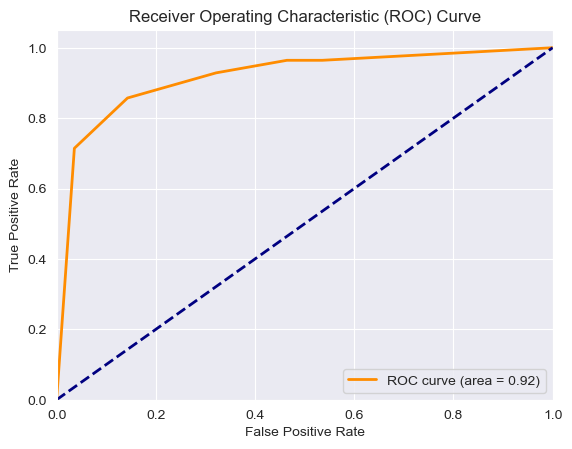

In [21]:
# Receiver Operating Characteristic (ROC) curve

from sklearn.metrics import roc_curve, roc_auc_score

# Get the probabilities for the positive class
testProbs = knnFit.predict_proba(X_test)  # Predict class probabilities

positive_class_index = 0
# Binary labels for positive class
y_test_binary = (y_test == knnFit.classes_[positive_class_index]).astype(int)  

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_binary, testProbs[:, positive_class_index])

# Compute AUC
roc_auc = roc_auc_score(y_test_binary, testProbs[:, positive_class_index])

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### 3.6 Model tuning and avoiding overfitting

### 3.7 Variable importance

### 3.8 How to deal with class imbalance

### 3.9 Dealing with correlated predictors

### 3.10 Random forests

### 3.11 Logistic regression and regularization

### 3.12 Other supervised algorithms

### 3.13 Predicting continuous variables: Regression with machine learning

### 3.14 Exercises